In [1]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# establish connection with AWS EC2 host; input host IP here
connection_args = {
    'host': '#.##.###.###', 
    'user': 'ubuntu',
    'dbname': 'sdss',    
    'port': 5432          
}

connection = pg.connect(**connection_args)

In [3]:
# get full photoprimary table row count
query = """
    SELECT COUNT(*)       
    FROM photoprimary AS p
    INNER JOIN specobj AS s ON p.objid = s.bestobjid
    WHERE (type = 6 AND class = 'STAR') OR 
          (type = 3 AND class = 'GALAXY') OR 
          (class = 'QSO');   
"""

pd_sql.read_sql(query, connection)

,count
0,3229302


In [14]:
# look at 10 rows from joined photoprimary-specobj table
# filter for objects matching 'star' in both tables, objects matching 'galaxy' in both tables, or objects 
# matching 'quasar' in specobj table

query = """
    SELECT  objid,  
            s.specobjid, 
            class, 
            p.ra, 
            p.dec, 
            s.z AS redshift,
            u, 
            g, 
            r, 
            i, 
            p.z,
            spectroflux_u,
            spectroflux_g, 
            spectroflux_r, 
            spectroflux_i, 
            spectroflux_z       
    FROM photoprimary AS p
    INNER JOIN specobj AS s ON p.objid = s.bestobjid
    WHERE (type = 6 AND class = 'STAR') OR 
          (type = 3 AND class = 'GALAXY') OR 
          (class = 'QSO')
    LIMIT 10;
"""

pd_sql.read_sql(query, connection)

,objid,specobjid,class,ra,dec,redshift,u,g,r,i,z,spectroflux_u,spectroflux_g,spectroflux_r,spectroflux_i,spectroflux_z
0,1237648704604471436,409948271046322176,STAR,245.921,0.157224,-0.000784,19.2158,17.8629,17.9782,18.0781,18.1470,61.11510,70.77350,62.1033,55.9497,48.8436
1,1237648703520309420,346818705755236352,GALAXY,222.089,-0.807538,0.056228,17.6402,16.2368,15.5232,15.1244,14.8350,12.10380,34.62440,80.1417,123.5950,160.4250
2,1237651752387412385,304085365851973632,GALAXY,151.934,1.038220,0.182405,19.8285,18.3418,17.3290,16.8407,16.5182,3.54406,7.32001,19.6642,31.2168,42.9237
3,1237648722316951761,338988538395650048,GALAXY,208.536,0.769607,0.102895,20.3301,18.4431,17.5159,17.0874,16.7807,5.85816,18.77310,49.0932,72.4772,96.5138
4,1237668567710564584,387390135584450560,GALAXY,240.171,-0.962358,0.156958,21.3720,19.0130,17.6304,17.0631,16.6155,4.98017,13.06420,42.0981,69.3377,99.1633
5,1237668567710368348,387391784851892224,GALAXY,239.771,-0.859197,0.134739,20.0098,18.6556,17.8918,17.5349,17.1827,3.74523,9.08954,19.4610,28.0186,35.5746
6,1237648704064848159,387393434119333888,GALAXY,239.618,-0.398803,0.124633,20.7429,18.8263,17.7027,17.2177,16.7813,3.07107,15.00350,47.8203,76.3665,108.1960
7,1237674650995392572,310898489653487616,GALAXY,163.973,0.457056,0.135212,19.3492,18.1395,17.4254,17.0177,16.7838,16.18050,30.92360,58.3489,85.8934,105.6530
8,1237648722290213007,300719480831502336,GALAXY,147.451,0.837753,0.143047,20.6187,18.4350,17.2143,16.7171,16.2846,6.55733,22.49350,70.6571,112.6350,160.2540
9,1237671264421675158,379503893534500864,GALAXY,192.530,-3.000830,0.088111,19.6116,18.2637,17.6217,17.1950,16.9399,8.04149,23.23310,43.5011,64.5274,76.8112


In [15]:
# make a cursor
cursor = connection.cursor()

In [24]:
# create view 'specphoto' from joined tables
query = """
    CREATE VIEW specphoto AS (
        SELECT s.specobjid,
               s.bestobjid,
               s.fluxobjid,
               s.class,
               s.subclass,
               s.z AS redshift,
               s.class_noqso,
               s.z_noqso AS redshift_noqso,
               s.spectroflux_u,
               s.spectroflux_g,
               s.spectroflux_r,
               s.spectroflux_i,
               s.spectroflux_z,
               p.objid,
               p.run,
               p.camcol,
               p.field,
               p.type,
               p.ra,
               p.dec,
               p.u,
               p.g,
               p.r,
               p.i,
               p.z
        FROM photoprimary AS p
        INNER JOIN specobj AS s ON p.objid = s.bestobjid
    );
"""

cursor.execute(query)

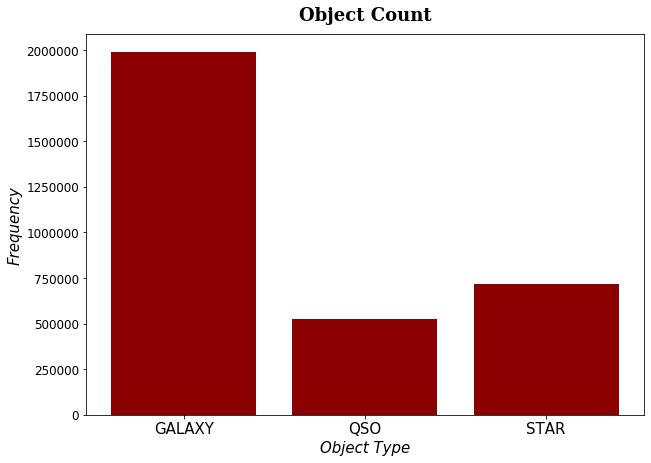

In [7]:
# compare class balance
query = """
    SELECT class, COUNT(*) AS n       
    FROM specphoto
    WHERE (type = 6 AND class = 'STAR') OR 
          (type = 3 AND class = 'GALAXY') OR 
          (class = 'QSO')
    GROUP BY class;
"""

class_count = pd_sql.read_sql(query, connection)

plt.figure(figsize = (10, 7))
plt.bar(class_count['class'], class_count['n'], color = 'darkred')
plt.title("Object Count", fontsize = 18, fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel("Object Type", fontsize = 15, style = 'italic')
plt.ylabel("Frequency", fontsize = 15, style = 'italic')
plt.xticks(fontsize = 15, rotation = 0)
plt.yticks(fontsize = 12)

plt.savefig('bar_objects_count.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

In [25]:
# bring in data as dataframe
query = """
    SELECT  objid,  
            specobjid, 
            class, 
            ra, 
            dec, 
            redshift,
            u, 
            g, 
            r, 
            i, 
            z,
            spectroflux_u,
            spectroflux_g, 
            spectroflux_r, 
            spectroflux_i, 
            spectroflux_z       
    FROM specphoto
    WHERE (type = 6 AND class = 'STAR') OR 
          (type = 3 AND class = 'GALAXY') OR 
          (class = 'QSO');
"""

specphoto = pd_sql.read_sql(query, connection)
specphoto.head()

,objid,specobjid,class,ra,dec,redshift,u,g,r,i,z,spectroflux_u,spectroflux_g,spectroflux_r,spectroflux_i,spectroflux_z
0,1237648704604471436,409948271046322176,STAR,245.921,0.157224,-0.000784,19.2158,17.8629,17.9782,18.0781,18.1470,61.11510,70.77350,62.1033,55.9497,48.8436
1,1237648703520309420,346818705755236352,GALAXY,222.089,-0.807538,0.056228,17.6402,16.2368,15.5232,15.1244,14.8350,12.10380,34.62440,80.1417,123.5950,160.4250
2,1237651752387412385,304085365851973632,GALAXY,151.934,1.038220,0.182405,19.8285,18.3418,17.3290,16.8407,16.5182,3.54406,7.32001,19.6642,31.2168,42.9237
3,1237648722316951761,338988538395650048,GALAXY,208.536,0.769607,0.102895,20.3301,18.4431,17.5159,17.0874,16.7807,5.85816,18.77310,49.0932,72.4772,96.5138
4,1237668567710564584,387390135584450560,GALAXY,240.171,-0.962358,0.156958,21.3720,19.0130,17.6304,17.0631,16.6155,4.98017,13.06420,42.0981,69.3377,99.1633


In [33]:
# count rows for specphoto-zoospec join
query = """
    SELECT COUNT(*)       
    FROM specphoto AS sp
    INNER JOIN zoospec AS z ON sp.objid = z.objid
    WHERE type = 3 AND class = 'GALAXY' AND uncertain != 1;   
"""

pd_sql.read_sql(query, connection)

,count
0,197937


In [34]:
# create view 'zoospecphoto' from joined tables
query = """
    CREATE VIEW zoospecphoto AS (
        SELECT sp.*,
               z.nvote,
               z.p_el,
               z.p_cw,
               z.p_acw,
               z.p_edge,
               z.p_dk,
               z.p_mg,
               z.p_cs,
               z.p_el_debiased,
               z.p_cs_debiased,
               z.spiral,
               z.elliptical,
               z.uncertain
        FROM specphoto AS sp
        INNER JOIN zoospec AS z ON sp.objid = z.objid
    );
"""

cursor.execute(query)

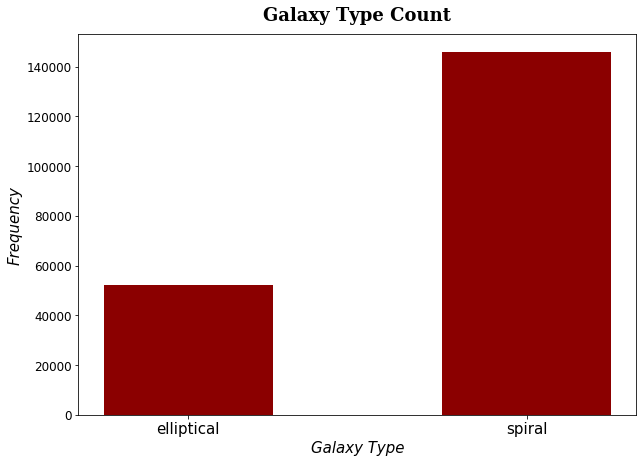

In [6]:
# compare class balance for zoospecphoto
query = """
    SELECT SUM(elliptical) AS elliptical, SUM(spiral) AS spiral        
    FROM zoospecphoto
    WHERE type = 3 AND class = 'GALAXY' AND uncertain != 1;
"""

class_count2 = pd_sql.read_sql(query, connection).melt()

plt.figure(figsize = (10, 7))
plt.bar(class_count2['variable'], class_count2['value'], color = 'darkred', width = 0.5)
plt.title("Galaxy Type Count", fontsize = 18, fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel("Galaxy Type", fontsize = 15, style = 'italic')
plt.ylabel("Frequency", fontsize = 15, style = 'italic')
plt.xticks(fontsize = 15, rotation = 0)
plt.yticks(fontsize = 12)

plt.savefig('bar_galaxies_count.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

In [35]:
# bring in joined zoospecphoto data as dataframe
query = """
    SELECT  objid,  
            specobjid, 
            spiral,
            elliptical,
            ra, 
            dec, 
            redshift,
            u, 
            g, 
            r, 
            i, 
            z,
            spectroflux_u,
            spectroflux_g, 
            spectroflux_r, 
            spectroflux_i, 
            spectroflux_z       
    FROM zoospecphoto
    WHERE type = 3 AND class = 'GALAXY' AND uncertain != 1;
"""

zoospecphoto = pd_sql.read_sql(query, connection)
zoospecphoto.head()

,objid,specobjid,spiral,elliptical,ra,dec,redshift,u,g,r,i,z,spectroflux_u,spectroflux_g,spectroflux_r,spectroflux_i,spectroflux_z
0,1237666407365738659,432400020604479488,0,1,353.328,-0.450154,0.058485,16.9770,15.0677,14.1465,13.6946,13.3555,34.10310,116.8900,291.0530,438.6530,588.1610
1,1237671266033992047,327804855638845440,1,0,191.461,1.021810,0.084116,19.1915,17.5387,16.7668,16.3710,16.0834,14.67950,34.7216,74.7768,111.4800,142.5410
2,1237671266033926439,327806779784194048,1,0,191.382,0.901669,0.089536,19.6597,18.0336,17.1419,16.6609,16.2882,7.39504,20.2385,48.7808,79.2346,108.3190
3,1237674602679501105,340026473110857728,1,0,212.940,-0.904272,0.054444,19.3794,17.5733,16.5850,16.0725,15.5990,7.77995,24.7948,65.6886,112.5340,161.2260
4,1237648703516115180,340036093837600768,1,0,212.542,-0.751769,0.107122,18.4530,17.1161,16.5073,16.1414,15.8843,7.55275,17.4532,35.0269,52.0750,65.6971


In [36]:
specphoto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3229302 entries, 0 to 3229301
Data columns (total 16 columns):
objid            int64
specobjid        int64
class            object
ra               float64
dec              float64
redshift         float64
u                float64
g                float64
r                float64
i                float64
z                float64
spectroflux_u    float64
spectroflux_g    float64
spectroflux_r    float64
spectroflux_i    float64
spectroflux_z    float64
dtypes: float64(13), int64(2), object(1)
memory usage: 394.2+ MB


In [37]:
zoospecphoto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197937 entries, 0 to 197936
Data columns (total 17 columns):
objid            197937 non-null int64
specobjid        197937 non-null int64
spiral           197937 non-null int64
elliptical       197937 non-null int64
ra               197937 non-null float64
dec              197937 non-null float64
redshift         197937 non-null float64
u                197937 non-null float64
g                197937 non-null float64
r                197937 non-null float64
i                197937 non-null float64
z                197937 non-null float64
spectroflux_u    197937 non-null float64
spectroflux_g    197937 non-null float64
spectroflux_r    197937 non-null float64
spectroflux_i    197937 non-null float64
spectroflux_z    197937 non-null float64
dtypes: float64(13), int64(4)
memory usage: 25.7 MB


In [40]:
# check for NaNs
specphoto[specphoto.isna().any(axis = 1)]

,objid,specobjid,class,ra,dec,redshift,u,g,r,i,z,spectroflux_u,spectroflux_g,spectroflux_r,spectroflux_i,spectroflux_z


In [41]:
zoospecphoto[zoospecphoto.isna().any(axis = 1)]

,objid,specobjid,spiral,elliptical,ra,dec,redshift,u,g,r,i,z,spectroflux_u,spectroflux_g,spectroflux_r,spectroflux_i,spectroflux_z


In [42]:
# export dataframes
specphoto.to_pickle('specphoto.pickle')
zoospecphoto.to_pickle('zoospecphoto.pickle')